# 基于wavelet_transform9的无LSTM版本，比较两者的准确度和注意力分布 2021.7.20

## with LSTM

### 模型训练

In [1]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB  

import pywt
import numpy as np

import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend, regularizers
import time

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

TRAINDATA_LOADPATH = 'tool_wear_data_8/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = 'tool_wear_data_8/train_label.npy' #训练集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_8/test_data.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_8/test_label.npy' #验证集标签读取路径

SUMMARY_PATH = './logs'     #记录路径
MODEL_SAVE_PATH = 'attention_distribution_with_LSTM/model.h5'
MODEL_SAVE_PATH2 = 'attention_distribution_with_LSTM/model2.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 2304
SIGNAL_LENGTH_2 = 48
SIGNAL_LENGTH_3 = 8

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 7]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
SCALE_NUM_VIBRATION = 3 #小波分解级数
SCALE_NUM_AE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 7]
LOWFREQ_LSTM_SIZE = 18
LOWFREQ_FEATURE_SIZE = 20
ATTENTION_SIZE = 23

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 6]
HIGHFREQ_LSTM_SIZE = 18
ATTENTION_RANGE = 48 #需要与splicing的个数对应
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]/SIGNAL_LENGTH_2

LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = int(SIGNAL_LENGTH_2/SIGNAL_LENGTH_3) #???
LOCAL_LSTM_SIZE = 25
LOCAL_DENSE_SIZE = 30

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE]
GLOBAL_LSTM_SIZE = 28
GLOBAL_DENSE_SIZE = 35

PREDICT_DENSE_SIZE = 200
OUTPUT_SIZE = 3

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH1 = 7
PREDICTOR_TRAIN_BATCH2 = 4


##############################数据集读取########################################
X_train=np.load(TRAINDATA_LOADPATH)
Y_train=np.load(TRAINLABEL_LOADPATH)
X_test=np.load(TESTDATA_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train[:(np.shape(X_train)[0]-np.shape(X_train)[0]%BATCH_SIZE), :,:INPUT_NUM]
Y_train = Y_train[:(np.shape(Y_train)[0]-np.shape(Y_train)[0]%BATCH_SIZE), :OUTPUT_SIZE]
X_test = X_test[:(np.shape(X_test)[0]-np.shape(X_test)[0]%BATCH_SIZE), :,:INPUT_NUM]
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]

############################################################小波分析##########################################################################################
#通过百分数滤除小尺度部分的噪声，输入小波信号整体
def percentile_compute(signal, percent): 
    percentile = np.percentile(np.abs(signal), percent)
    signal[np.abs(signal) < percentile] = 0
    return signal

def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

#         plt.figure(figsize=(30,2))
#         plt.plot(data[sample_index, :1024, j])
#         plt.show()
#         plt.figure(figsize=(30,2))
#         plt.plot(coeffs_lowfreq[sample_index, :128])
#         plt.show()
#         plt.figure(figsize=(30,2))
#         plt.plot(coeffs_highfreq[sample_index, :1024])
#         plt.show()
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train[:, :, 0:3], SCALE_NUM_FORCE)
coeffs_train_vibration = wavelet_transform(X_train[:, :, 3:6], SCALE_NUM_VIBRATION)
coeffs_train_AE = wavelet_transform(X_train[:, :, 6].reshape([np.shape(X_train)[0], np.shape(X_train)[1], 1]), SCALE_NUM_AE)
coeffs_train_AE = coeffs_train_AE[0]
coeffs_lowfreq_train = np.concatenate([coeffs_train_force[0], coeffs_train_vibration[0], coeffs_train_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
coeffs_highfreq_train = np.concatenate([coeffs_train_force[1], coeffs_train_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train))
print('Y_train', np.shape(Y_train))

coeffs_test_force = wavelet_transform(X_test[:, :, 0:3], SCALE_NUM_FORCE)
coeffs_test_vibration = wavelet_transform(X_test[:, :, 3:6], SCALE_NUM_VIBRATION)
coeffs_test_AE = wavelet_transform(X_test[:, :, 6].reshape([np.shape(X_test)[0], np.shape(X_test)[1], 1]), SCALE_NUM_AE)
coeffs_test_AE = coeffs_test_AE[0]
coeffs_lowfreq_test = np.concatenate([coeffs_test_force[0], coeffs_test_vibration[0], coeffs_test_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
coeffs_highfreq_test = np.concatenate([coeffs_test_force[1], coeffs_test_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test))
print('Y_test', np.shape(Y_test))

##############################################################################################频带模型搭建###############################################################
def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::6])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.TimeDistributed(layers.LeakyReLU())(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.TimeDistributed(layers.LeakyReLU())(query)
    query = layers.LayerNormalization(axis = 1)(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    print('11', np.shape(x))
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.TimeDistributed(layers.LeakyReLU())(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.TimeDistributed(layers.LeakyReLU())(value)
    key = layers.LayerNormalization(axis = 1)(key)
    value = layers.LayerNormalization(axis = 1)(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(lowhigh_freq_Attention,self).__init__(**kwargs)
    def build(self, input_shape):
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): 
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.matmul(distribution, value)
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) 
    
class temporal_Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(temporal_Attention,self).__init__(**kwargs)
    def build(self, input_shape): 
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        super(temporal_Attention,self).build(input_shape)
    def call(self, key):
        scores = tf.matmul(self.u_query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])

#高低频时序特征提取
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
print('query', np.shape(query))
print('feature_lowfreq', np.shape(feature_lowfreq))
key, value = model_highfreq(input_highfreq)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
print('query', np.shape(query))
value = layers.Reshape([-1, int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), ATTENTION_SIZE])(value)
print('value', np.shape(value))
key = layers.Reshape([-1, int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), ATTENTION_SIZE])(key)
print('key', np.shape(key))
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
print('feature_highfreq', np.shape(feature_highfreq))
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])

###############################################LSTM模型搭建###############################################################
def localLSTM_construct(input_size, timestep, lstm_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='input')
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.TimeDistributed(layers.LeakyReLU())(x)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, LOCAL_TIMESTEP, LOCAL_LSTM_SIZE, LOCAL_DENSE_SIZE, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local(feature_freq)
print('feature_local', feature_local)

def globalLSTM_construct(input_size, lstm_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='input')
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.TimeDistributed(layers.LeakyReLU())(x)
#     x = layers.LayerNormalization(axis = 1)(x)
    outputs, att_distribution_global = temporal_Attention()(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=outputs, name = name)
    return biLSTM_model

biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_LSTM_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
feature = biLSTM_global(feature_local)
print('feature', feature)
x = layers.Dense(PREDICT_DENSE_SIZE)(feature)
x = layers.LeakyReLU()(x)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(OUTPUT_SIZE, name='output')(x)
output = layers.LeakyReLU()(x)
predictor = models.Model(inputs=[input_lowfreq, input_highfreq], outputs=output, name='tool_wear_predictor')
att_distribution_model = models.Model(inputs=[input_lowfreq, input_highfreq], 
                                      outputs=[att_distribution_lowhigh, att_distribution_local], 
                                      name = 'att_distribution_model')

predictor.summary()
#############################################模型训练#########################################################################
time_start = time.time()

adam = keras.optimizers.Adam(lr=0.008)
predictor.compile(optimizer=adam, loss = 'mse')

history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, batch_size=BATCH_SIZE, 
                        validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test),
                        epochs=PREDICTOR_TRAIN_BATCH1,  shuffle=True, verbose=1)

adam = keras.optimizers.Adam(lr=0.001)
predictor.compile(optimizer=adam, loss = 'mse')
history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, batch_size=BATCH_SIZE, 
                        validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test),
                        epochs=PREDICTOR_TRAIN_BATCH2,  shuffle=True, verbose=1)

predictor.save(MODEL_SAVE_PATH)
att_distribution_model.save(MODEL_SAVE_PATH2)
print('time1 =  ', time.time()-time_start)


coeffs_lowfreq_train (17088, 288, 7)
coeffs_highfreq_train (17088, 2304, 6)
Y_train (17088, 3)
coeffs_lowfreq_test (4224, 288, 7)
coeffs_highfreq_test (4224, 2304, 6)
Y_test (4224, 3)
11 (64, 2304, 36)
query (64, 48, 23)
feature_lowfreq (64, 48, 20)
query (64, 48, 1, 23)
value (64, 48, 48, 23)
key (64, 48, 48, 23)
feature_highfreq (64, 48, 23)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 8, 30), dtype=tf.float32, name=None), name='biLSTM_local/time_distributed_11/transpose_1:0', description="created by layer 'biLSTM_local'")
feature KerasTensor(type_spec=TensorSpec(shape=(64, 35), dtype=tf.float32, name=None), name='biLSTM_global/temporal__attention_1/Squeeze:0', description="created by layer 'biLSTM_global'")
Model: "tool_wear_predictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lowfreq (InputLayer)      [(64, 28

### 结果显示

In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
import pywt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import time

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off 
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

TRAINDATA_LOADPATH = 'tool_wear_data_8/train_data.npy'
TRAINLABEL_LOADPATH =  'tool_wear_data_8/train_label.npy'
TESTDATA1_LOADPATH = 'tool_wear_data_8/test_data1.npy'
TESTDATA2_LOADPATH = 'tool_wear_data_8/test_data2.npy'
TESTLABEL_LOADPATH =  'tool_wear_data_8/test_label.npy'

MODEL_LOAD_PATH = 'attention_distribution_with_LSTM/model.h5'
MODEL_LOAD_PATH2 = 'attention_distribution_with_LSTM/model2.h5'

#输入数据
INPUT_SIZE = [2304, 7]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
SCALE_NUM_VIBRATION = 3 #小波分解级数
SCALE_NUM_AE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

ATTENTION_RANGE = 48
OUTPUT_SIZE = 3
BATCH_SIZE = 64
size = 15

#################################################模型加载###################################################
class lowhigh_freq_Attention(layers.Layer):
    def __init__(self, **kwargs): 
        super(lowhigh_freq_Attention,self).__init__(**kwargs) 
    def build(self, input_shape): 
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): 
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.matmul(distribution, value)
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE)
    
class temporal_Attention(layers.Layer):
    def __init__(self, **kwargs): 
        super(temporal_Attention,self).__init__(**kwargs)
    def build(self, input_shape): 
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        super(temporal_Attention,self).build(input_shape)
    def call(self, key):
        scores = tf.matmul(self.u_query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])

def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

################################################### 数据集读取及处理 ##################################################
#test1
X_test1=np.load(TESTDATA1_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)
X_test1 = X_test1[:(np.shape(X_test1)[0]-np.shape(X_test1)[0]%BATCH_SIZE),:, :INPUT_NUM]
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]

coeffs_test_force = wavelet_transform(X_test1[:, :, 0:3], SCALE_NUM_FORCE)
coeffs_test_vibration = wavelet_transform(X_test1[:, :, 3:6], SCALE_NUM_VIBRATION)
coeffs_test_AE = wavelet_transform(X_test1[:, :, 6].reshape([np.shape(X_test1)[0], np.shape(X_test1)[1], 1]), SCALE_NUM_AE)
coeffs_test_AE = coeffs_test_AE[0]
coeffs_lowfreq_test1 = np.concatenate([coeffs_test_force[0], coeffs_test_vibration[0], coeffs_test_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
coeffs_highfreq_test1 = np.concatenate([coeffs_test_force[1], coeffs_test_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
print('coeffs_lowfreq_test1', np.shape(coeffs_lowfreq_test1))
print('coeffs_highfreq_test1', np.shape(coeffs_highfreq_test1))
print('Y_test', np.shape(Y_test))

################################################### 模型读取及预测 ##################################################
predictor = keras.models.load_model(MODEL_LOAD_PATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                     'temporal_Attention':temporal_Attention})
att_distribution_model = keras.models.load_model(MODEL_LOAD_PATH2, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                                   'temporal_Attention':temporal_Attention})

#test1
score1 = predictor.evaluate([coeffs_lowfreq_test1, coeffs_highfreq_test1], Y_test, verbose=0, batch_size = BATCH_SIZE)
Y_pre_test1 = predictor.predict([coeffs_lowfreq_test1, coeffs_highfreq_test1], batch_size = BATCH_SIZE)

v = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
result = [np.convolve(Y_pre_test1[:, 0], v, mode='same'), np.convolve(Y_pre_test1[:, 1], v, mode='same'), 
          np.convolve(Y_pre_test1[:, 2], v, mode='same')]
result = np.transpose(result)

axis = np.linspace(1, 314, np.shape(result)[0])
print('loss_test_avg', np.mean(np.square(result - Y_test)))
print('percent_test_avg', np.mean(np.abs(result - Y_test)/Y_test)*100, '%')
print('done')

coeffs_lowfreq_test1 (4224, 288, 7)
coeffs_highfreq_test1 (4224, 2304, 6)
Y_test (4224, 3)
loss_test_avg 0.0007154659937288591
percent_test_avg 2.550097968162294 %
done


### 注意力权重存储

att_distribution_value_local (4224, 48)
att_distribution_value_lowhigh (4224, 2304)
att_distribution_value_detail (4224, 2304)


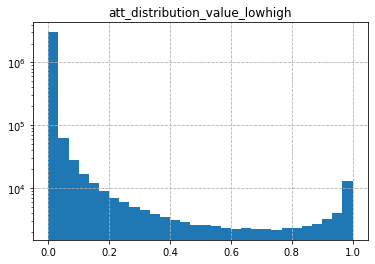

[9.33150166e-01 1.93459867e-02 8.75669537e-03 5.26597765e-03
 3.73516661e-03 2.77278399e-03 2.17722883e-03 1.83567856e-03
 1.57335069e-03 1.38346354e-03 1.19018555e-03 1.08167860e-03
 9.45428405e-04 9.00422684e-04 8.04554332e-04 7.89757931e-04
 7.74036754e-04 7.24407158e-04 6.92040029e-04 7.08994239e-04
 6.85874862e-04 6.99129972e-04 6.68304135e-04 7.16700698e-04
 7.29031033e-04 7.61398161e-04 8.16576409e-04 9.92900193e-04
 1.26231800e-03 4.05976267e-03]


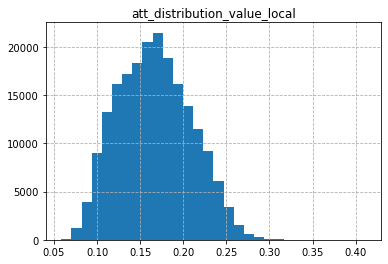

[1.72624684e-04 5.82978220e-03 1.91514757e-02 4.45026436e-02
 6.52422664e-02 7.97575363e-02 8.47439236e-02 9.02284564e-02
 1.01256708e-01 1.05917574e-01 9.32370581e-02 7.97230114e-02
 6.82015467e-02 5.67836569e-02 4.54150884e-02 3.00613557e-02
 1.69270833e-02 7.38340436e-03 3.07271938e-03 1.46977588e-03
 6.21448864e-04 2.07149621e-04 7.39820076e-05 9.86426768e-06
 4.93213384e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.93213384e-06]


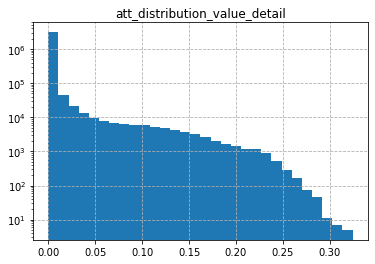

[9.51965949e-01 1.41641636e-02 6.50702582e-03 4.06623609e-03
 2.96637025e-03 2.37050683e-03 2.06841363e-03 1.94726809e-03
 1.87421086e-03 1.79344717e-03 1.60633434e-03 1.46299420e-03
 1.30177507e-03 1.16059274e-03 9.96291035e-04 8.30756293e-04
 6.16824988e-04 5.14174953e-04 4.52831538e-04 3.61895320e-04
 3.50489761e-04 2.71883878e-04 1.65226484e-04 8.87784091e-05
 5.08626302e-05 2.31193774e-05 1.44881432e-05 3.39084201e-06
 2.15780855e-06 1.54129182e-06]


In [2]:
#
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d
import pandas as pd
import seaborn as sns

ATT_LOCAL_SAVEPATH = 'attention_distribution_with_LSTM/attention_local.npy'
ATT_LOWHIGH_SAVEPATH = 'attention_distribution_with_LSTM/attention_lowhigh.npy'
ATT_DETAIL_SAVEPATH = 'attention_distribution_with_LSTM/attention_detail.npy'

att_distribution_value_lowhigh, att_distribution_value_local = att_distribution_model.predict(
    [coeffs_lowfreq_test1, coeffs_highfreq_test1], batch_size = BATCH_SIZE)
att_distribution_value_local = att_distribution_value_local.reshape([np.shape(att_distribution_value_local)[0], -1])
np.save(ATT_LOCAL_SAVEPATH, att_distribution_value_local)#(1280, 48)
np.save(ATT_LOWHIGH_SAVEPATH, att_distribution_value_lowhigh.reshape([np.shape(att_distribution_value_lowhigh)[0], -1]))#(1280, 2304)

######################local_attention插值##########################################
att_distribution_value_local = np.expand_dims(att_distribution_value_local, axis=2)#(1280, 48, 1)
att_distribution_value_detail = att_distribution_value_lowhigh * att_distribution_value_local#(1280, 48, 48)
att_distribution_value_detail = att_distribution_value_detail.reshape(np.shape(att_distribution_value_detail)[0], -1)

np.save(ATT_DETAIL_SAVEPATH, att_distribution_value_detail)
att_distribution_value_local = att_distribution_value_local.reshape(np.shape(att_distribution_value_local)[0], -1)
att_distribution_value_lowhigh = att_distribution_value_lowhigh.reshape(np.shape(att_distribution_value_lowhigh)[0], -1)
print('att_distribution_value_local', np.shape(att_distribution_value_local))
print('att_distribution_value_lowhigh', np.shape(att_distribution_value_lowhigh))
print('att_distribution_value_detail', np.shape(att_distribution_value_detail))

plt.title('att_distribution_value_lowhigh') 
a, b, c = plt.hist(att_distribution_value_lowhigh[::3].reshape([-1]), bins=30, density=False, log=True)
plt.grid(linestyle='--')
plt.show()
print(a/np.sum(a))

plt.title('att_distribution_value_local') 
a, b, c = plt.hist(att_distribution_value_local.reshape([-1]), bins=30, density=False, log=False)
plt.grid(linestyle='--')
plt.show()
print(a/np.sum(a))

plt.title('att_distribution_value_detail') 
a, b, c = plt.hist(att_distribution_value_detail[::3].reshape([-1]), bins=30, density=False, log=True)
plt.grid(linestyle='--')
plt.show()
print(a/np.sum(a))


## without LSTM

### 模型训练

In [1]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB  

import pywt
import numpy as np

import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend, regularizers
import time

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

TRAINDATA_LOADPATH = 'tool_wear_data_8/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = 'tool_wear_data_8/train_label.npy' #训练集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_8/test_data.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_8/test_label.npy' #验证集标签读取路径

SUMMARY_PATH = './logs'     #记录路径
MODEL_SAVE_PATH = 'attention_distribution_without_LSTM/model.h5'
MODEL_SAVE_PATH2 = 'attention_distribution_without_LSTM/model2.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 2304
SIGNAL_LENGTH_2 = 48
SIGNAL_LENGTH_3 = 8

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 7]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
SCALE_NUM_VIBRATION = 3 #小波分解级数
SCALE_NUM_AE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 7]
LOWFREQ_LSTM_SIZE = 18
LOWFREQ_FEATURE_SIZE = 20
ATTENTION_SIZE = 23

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 6]
HIGHFREQ_LSTM_SIZE = 18
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = 48 #需要与splicing的个数对应
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]/SIGNAL_LENGTH_2

LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = int(SIGNAL_LENGTH_2/SIGNAL_LENGTH_3) #???
LOCAL_LSTM_SIZE = 25
LOCAL_DENSE_SIZE = 30

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE]
GLOBAL_LSTM_SIZE = 28
GLOBAL_DENSE_SIZE = 35

PREDICT_DENSE_SIZE = 200
OUTPUT_SIZE = 3

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH1 = 7
PREDICTOR_TRAIN_BATCH2 = 4


##############################数据集读取########################################
X_train=np.load(TRAINDATA_LOADPATH)
Y_train=np.load(TRAINLABEL_LOADPATH)
X_test=np.load(TESTDATA_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train[:(np.shape(X_train)[0]-np.shape(X_train)[0]%BATCH_SIZE), :,:INPUT_NUM]
Y_train = Y_train[:(np.shape(Y_train)[0]-np.shape(Y_train)[0]%BATCH_SIZE), :OUTPUT_SIZE]
X_test = X_test[:(np.shape(X_test)[0]-np.shape(X_test)[0]%BATCH_SIZE), :,:INPUT_NUM]
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]

############################################################小波分析##########################################################################################
#通过百分数滤除小尺度部分的噪声，输入小波信号整体
def percentile_compute(signal, percent): 
    percentile = np.percentile(np.abs(signal), percent)
    signal[np.abs(signal) < percentile] = 0
    return signal

def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

#         plt.figure(figsize=(30,2))
#         plt.plot(data[sample_index, :1024, j])
#         plt.show()
#         plt.figure(figsize=(30,2))
#         plt.plot(coeffs_lowfreq[sample_index, :128])
#         plt.show()
#         plt.figure(figsize=(30,2))
#         plt.plot(coeffs_highfreq[sample_index, :1024])
#         plt.show()
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train[:, :, 0:3], SCALE_NUM_FORCE)
coeffs_train_vibration = wavelet_transform(X_train[:, :, 3:6], SCALE_NUM_VIBRATION)
coeffs_train_AE = wavelet_transform(X_train[:, :, 6].reshape([np.shape(X_train)[0], np.shape(X_train)[1], 1]), SCALE_NUM_AE)
coeffs_train_AE = coeffs_train_AE[0]
coeffs_lowfreq_train = np.concatenate([coeffs_train_force[0], coeffs_train_vibration[0], coeffs_train_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
coeffs_highfreq_train = np.concatenate([coeffs_train_force[1], coeffs_train_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train))
print('Y_train', np.shape(Y_train))

coeffs_test_force = wavelet_transform(X_test[:, :, 0:3], SCALE_NUM_FORCE)
coeffs_test_vibration = wavelet_transform(X_test[:, :, 3:6], SCALE_NUM_VIBRATION)
coeffs_test_AE = wavelet_transform(X_test[:, :, 6].reshape([np.shape(X_test)[0], np.shape(X_test)[1], 1]), SCALE_NUM_AE)
coeffs_test_AE = coeffs_test_AE[0]
coeffs_lowfreq_test = np.concatenate([coeffs_test_force[0], coeffs_test_vibration[0], coeffs_test_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
coeffs_highfreq_test = np.concatenate([coeffs_test_force[1], coeffs_test_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test))
print('Y_test', np.shape(Y_test))

##############################################################################################频带模型搭建###############################################################
def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Lambda(lambda x: x[:, ::6])(inputs)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
    print('x1', np.shape(x))
    outputs = layers.TimeDistributed(layers.Dense(output_size, activation='tanh'))(x)
    query = layers.TimeDistributed(layers.Dense(attention_size, activation='tanh'))(x)
    query = layers.LayerNormalization(axis = 1)(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
    print('inputs', np.shape(inputs))
    key = layers.TimeDistributed(layers.Dense(attention_size, activation='tanh'))(inputs)
    value = layers.TimeDistributed(layers.Dense(attention_size, activation='tanh'))(inputs)
    key = layers.LayerNormalization(axis = 1)(key)
    value = layers.LayerNormalization(axis = 1)(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    def __init__(self, **kwargs): #初始化方法
        super(lowhigh_freq_Attention,self).__init__(**kwargs) 
    def build(self, input_shape):
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x):
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.matmul(distribution, value)
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
class temporal_Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(temporal_Attention,self).__init__(**kwargs)
    def build(self, input_shape): 
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        super(temporal_Attention,self).build(input_shape)
    def call(self, key): 
        scores = tf.matmul(self.u_query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])
    
#高低频时序特征提取
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
print('query', np.shape(query))
print('feature_lowfreq', np.shape(feature_lowfreq))
key, value = model_highfreq(input_highfreq)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
print('query', np.shape(query))
value = layers.Reshape([-1, int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), ATTENTION_SIZE])(value)
print('value', np.shape(value))
key = layers.Reshape([-1, int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), ATTENTION_SIZE])(key)
print('key', np.shape(key))
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
print('feature_highfreq', np.shape(feature_highfreq))
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])

###############################################LSTM模型搭建###############################################################
def localLSTM_construct(input_size, timestep, lstm_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='input')
    x = layers.TimeDistributed(layers.Dense(dense_size, activation='tanh'))(inputs)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, LOCAL_TIMESTEP, LOCAL_LSTM_SIZE, LOCAL_DENSE_SIZE, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local(feature_freq)
print('feature_local', feature_local)

def globalLSTM_construct(input_size, lstm_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='input')
    x = layers.Bidirectional(layers.LSTM(lstm_size, return_sequences=False, name='biLSTM1'))(inputs)
    outputs = layers.Dense(dense_size, activation='tanh')(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=outputs, name = name)
    return biLSTM_model

biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_LSTM_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
feature = biLSTM_global(feature_local)
print('feature', feature)
x = layers.Dense(PREDICT_DENSE_SIZE, activation='tanh')(feature)
# x = layers.LeakyReLU()(x)
# x = layers.Dropout(0.5)(x)
output = layers.Dense(OUTPUT_SIZE, activation='tanh', name='output')(x)
# output = layers.LeakyReLU()(x)
predictor = models.Model(inputs=[input_lowfreq, input_highfreq], outputs=output, name='tool_wear_predictor')
att_distribution_model = models.Model(inputs=[input_lowfreq, input_highfreq], 
                                      outputs=[att_distribution_lowhigh, att_distribution_local], 
                                      name = 'att_distribution_model')

predictor.summary()
#############################################模型训练#########################################################################
time_start = time.time()
adam = keras.optimizers.Adam(lr=0.008)
predictor.compile(optimizer=adam, loss = 'mse')

history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, batch_size=BATCH_SIZE, 
                        validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test),
                        epochs=PREDICTOR_TRAIN_BATCH1,  shuffle=True, verbose=1)

adam = keras.optimizers.Adam(lr=0.001)
predictor.compile(optimizer=adam, loss = 'mse')
history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, batch_size=BATCH_SIZE, 
                        validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test),
                        epochs=PREDICTOR_TRAIN_BATCH2,  shuffle=True, verbose=1)

predictor.save(MODEL_SAVE_PATH)
att_distribution_model.save(MODEL_SAVE_PATH2)
print('time1 =  ', time.time()-time_start)


coeffs_lowfreq_train (17088, 288, 7)
coeffs_highfreq_train (17088, 2304, 6)
Y_train (17088, 3)
coeffs_lowfreq_test (4224, 288, 7)
coeffs_highfreq_test (4224, 2304, 6)
Y_test (4224, 3)
x1 (64, 48, 7)
inputs (64, 2304, 6)
query (64, 48, 23)
feature_lowfreq (64, 48, 20)
query (64, 48, 1, 23)
value (64, 48, 48, 23)
key (64, 48, 48, 23)
feature_highfreq (64, 48, 23)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 8, 30), dtype=tf.float32, name=None), name='biLSTM_local/time_distributed_6/transpose_1:0', description="created by layer 'biLSTM_local'")
feature KerasTensor(type_spec=TensorSpec(shape=(64, 35), dtype=tf.float32, name=None), name='biLSTM_global/dense_5/Tanh:0', description="created by layer 'biLSTM_global'")
Model: "tool_wear_predictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lowfreq (InputLayer)      [(64, 28

### 结果显示

In [2]:
#
import numpy as np
import matplotlib.pyplot as plt
import pywt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import time

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off 
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

TRAINDATA_LOADPATH = 'tool_wear_data_8/train_data.npy'
TRAINLABEL_LOADPATH =  'tool_wear_data_8/train_label.npy'
TESTDATA1_LOADPATH = 'tool_wear_data_8/test_data1.npy'
TESTDATA2_LOADPATH = 'tool_wear_data_8/test_data2.npy'
TESTLABEL_LOADPATH =  'tool_wear_data_8/test_label.npy'

MODEL_LOAD_PATH = 'attention_distribution_without_LSTM/model.h5'
MODEL_LOAD_PATH2 = 'attention_distribution_without_LSTM/model2.h5'

#输入数据
INPUT_SIZE = [2304, 7]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
SCALE_NUM_VIBRATION = 3 #小波分解级数
SCALE_NUM_AE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

ATTENTION_RANGE = 48
OUTPUT_SIZE = 3
BATCH_SIZE = 64
size = 15

#################################################模型加载###################################################
class lowhigh_freq_Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(lowhigh_freq_Attention,self).__init__(**kwargs) 
    def build(self, input_shape):
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x):
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.matmul(distribution, value)
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) 
    
class temporal_Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(temporal_Attention,self).__init__(**kwargs)
    def build(self, input_shape): 
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        super(temporal_Attention,self).build(input_shape)
    def call(self, key): 
        scores = tf.matmul(self.u_query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])

def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

################################################### 数据集读取及处理 ##################################################
#test1
X_test1=np.load(TESTDATA1_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)
X_test1 = X_test1[:(np.shape(X_test1)[0]-np.shape(X_test1)[0]%BATCH_SIZE),:, :INPUT_NUM]
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]

coeffs_test_force = wavelet_transform(X_test1[:, :, 0:3], SCALE_NUM_FORCE)
coeffs_test_vibration = wavelet_transform(X_test1[:, :, 3:6], SCALE_NUM_VIBRATION)
coeffs_test_AE = wavelet_transform(X_test1[:, :, 6].reshape([np.shape(X_test1)[0], np.shape(X_test1)[1], 1]), SCALE_NUM_AE)
coeffs_test_AE = coeffs_test_AE[0]
coeffs_lowfreq_test1 = np.concatenate([coeffs_test_force[0], coeffs_test_vibration[0], coeffs_test_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
coeffs_highfreq_test1 = np.concatenate([coeffs_test_force[1], coeffs_test_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
print('coeffs_lowfreq_test1', np.shape(coeffs_lowfreq_test1))
print('coeffs_highfreq_test1', np.shape(coeffs_highfreq_test1))
print('Y_test', np.shape(Y_test))

################################################### 模型读取及预测 ##################################################
predictor = keras.models.load_model(MODEL_LOAD_PATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                     'temporal_Attention':temporal_Attention})
att_distribution_model = keras.models.load_model(MODEL_LOAD_PATH2, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                                   'temporal_Attention':temporal_Attention})

#test1
score1 = predictor.evaluate([coeffs_lowfreq_test1, coeffs_highfreq_test1], Y_test, verbose=0, batch_size = BATCH_SIZE)
Y_pre_test1 = predictor.predict([coeffs_lowfreq_test1, coeffs_highfreq_test1], batch_size = BATCH_SIZE)

v = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
result = [np.convolve(Y_pre_test1[:, 0], v, mode='same'), np.convolve(Y_pre_test1[:, 1], v, mode='same'), 
          np.convolve(Y_pre_test1[:, 2], v, mode='same')]
result = np.transpose(result)

axis = np.linspace(1, 314, np.shape(result)[0])
print('loss_test_avg', np.mean(np.square(result - Y_test)))
print('percent_test_avg', np.mean(np.abs(result - Y_test)/Y_test)*100, '%')
print('done')

coeffs_lowfreq_test1 (4224, 288, 7)
coeffs_highfreq_test1 (4224, 2304, 6)
Y_test (4224, 3)
loss_test_avg 0.0008225991672865564
percent_test_avg 3.477989538681635 %
done


### 注意力存储

att_distribution_value_local (4224, 48)
att_distribution_value_lowhigh (4224, 2304)
att_distribution_value_detail (4224, 2304)


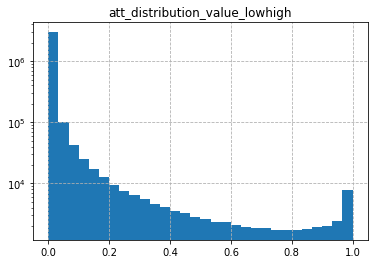

[9.13195061e-01 3.08498806e-02 1.30800189e-02 7.73666844e-03
 5.31221640e-03 3.92412899e-03 2.94602519e-03 2.34153054e-03
 1.97593612e-03 1.69110539e-03 1.44357392e-03 1.28173828e-03
 1.09678326e-03 1.00461401e-03 8.76378531e-04 8.20892026e-04
 7.35504459e-04 7.15775923e-04 6.37478299e-04 6.05727687e-04
 5.73052300e-04 5.73052300e-04 5.44076014e-04 5.36677813e-04
 5.36677813e-04 5.57947640e-04 5.94322128e-04 6.32854423e-04
 7.39511817e-04 2.44078973e-03]


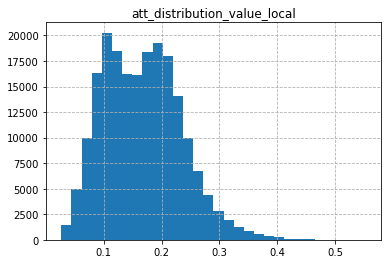

[7.15652620e-03 2.47346512e-02 4.93410669e-02 8.03839173e-02
 9.99792850e-02 9.09189552e-02 7.99301610e-02 7.97131471e-02
 9.07216698e-02 9.49928977e-02 8.88080019e-02 6.92224984e-02
 4.90599353e-02 3.34102746e-02 2.14202573e-02 1.37063999e-02
 9.36612216e-03 5.94815341e-03 4.08380682e-03 2.85077336e-03
 1.88407513e-03 1.17384785e-03 5.52398990e-04 3.05792298e-04
 1.67692551e-04 7.39820076e-05 5.42534722e-05 2.46606692e-05
 4.93213384e-06 9.86426768e-06]


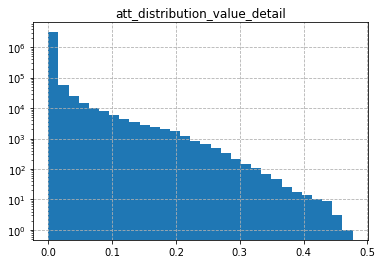

[9.56640687e-01 1.73663515e-02 7.53691702e-03 4.39144867e-03
 3.20927784e-03 2.53326724e-03 1.84985845e-03 1.33938260e-03
 1.05486012e-03 8.46477470e-04 7.35504459e-04 6.41793916e-04
 5.54248540e-04 3.82856889e-04 2.55854443e-04 2.03450521e-04
 1.49197049e-04 1.05732619e-04 6.35012232e-05 4.43892045e-05
 3.45249369e-05 2.09615688e-05 1.47964015e-05 7.70645912e-06
 5.54865057e-06 4.31561711e-06 3.08258365e-06 2.77432528e-06
 9.24775095e-07 3.08258365e-07]


In [3]:
#
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d
import pandas as pd
import seaborn as sns

ATT_LOCAL_SAVEPATH = 'attention_distribution_without_LSTM/attention_local.npy'
ATT_LOWHIGH_SAVEPATH = 'attention_distribution_without_LSTM/attention_lowhigh.npy'
ATT_DETAIL_SAVEPATH = 'attention_distribution_without_LSTM/attention_detail.npy'

att_distribution_value_lowhigh, att_distribution_value_local = att_distribution_model.predict(
    [coeffs_lowfreq_test1, coeffs_highfreq_test1], batch_size = BATCH_SIZE)
att_distribution_value_local = att_distribution_value_local.reshape([np.shape(att_distribution_value_local)[0], -1])
np.save(ATT_LOCAL_SAVEPATH, att_distribution_value_local)#(1280, 48)
np.save(ATT_LOWHIGH_SAVEPATH, att_distribution_value_lowhigh.reshape([np.shape(att_distribution_value_lowhigh)[0], -1]))#(1280, 2304)

######################local_attention插值##########################################
att_distribution_value_local = np.expand_dims(att_distribution_value_local, axis=2)#(1280, 48, 1)
att_distribution_value_detail = att_distribution_value_lowhigh * att_distribution_value_local#(1280, 48, 48)
att_distribution_value_detail = att_distribution_value_detail.reshape(np.shape(att_distribution_value_detail)[0], -1)

np.save(ATT_DETAIL_SAVEPATH, att_distribution_value_detail)
att_distribution_value_local = att_distribution_value_local.reshape(np.shape(att_distribution_value_local)[0], -1)
att_distribution_value_lowhigh = att_distribution_value_lowhigh.reshape(np.shape(att_distribution_value_lowhigh)[0], -1)
print('att_distribution_value_local', np.shape(att_distribution_value_local))
print('att_distribution_value_lowhigh', np.shape(att_distribution_value_lowhigh))
print('att_distribution_value_detail', np.shape(att_distribution_value_detail))

plt.title('att_distribution_value_lowhigh') 
a, b, c = plt.hist(att_distribution_value_lowhigh[::3].reshape([-1]), bins=30, density=False, log=True)
plt.grid(linestyle='--')
plt.show()
print(a/np.sum(a))

plt.title('att_distribution_value_local') 
a, b, c = plt.hist(att_distribution_value_local.reshape([-1]), bins=30, density=False, log=False)
plt.grid(linestyle='--')
plt.show()
print(a/np.sum(a))

plt.title('att_distribution_value_detail') 
a, b, c = plt.hist(att_distribution_value_detail[::3].reshape([-1]), bins=30, density=False, log=True)
plt.grid(linestyle='--')
plt.show()
print(a/np.sum(a))


## 有无LSTM的注意力分布比较

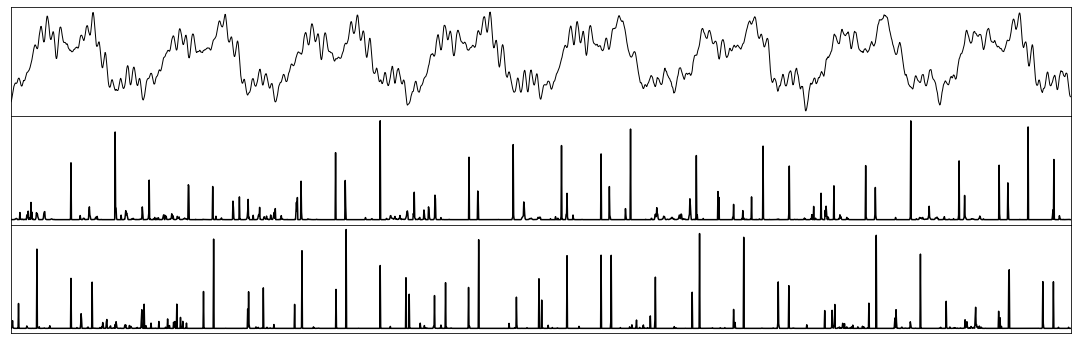

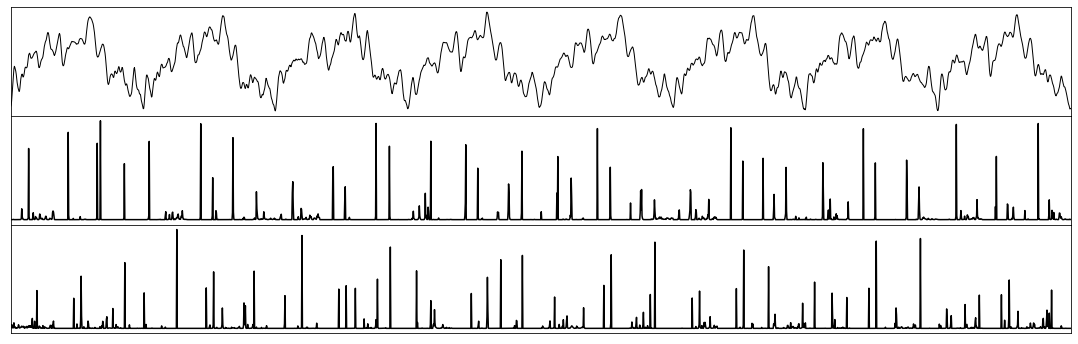

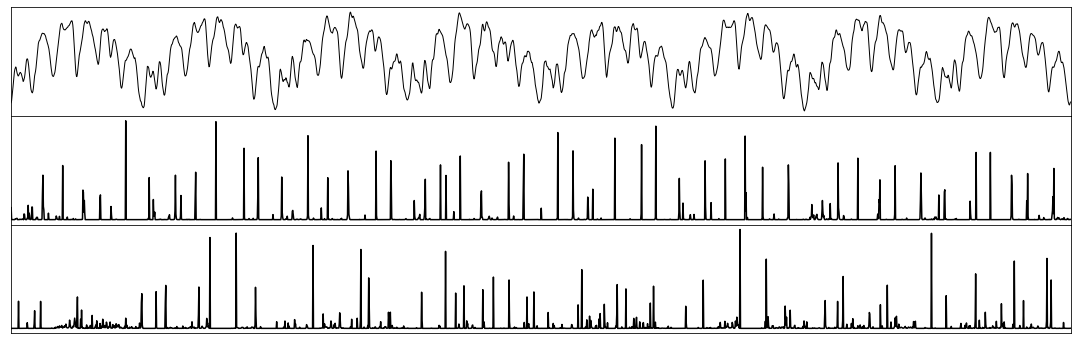

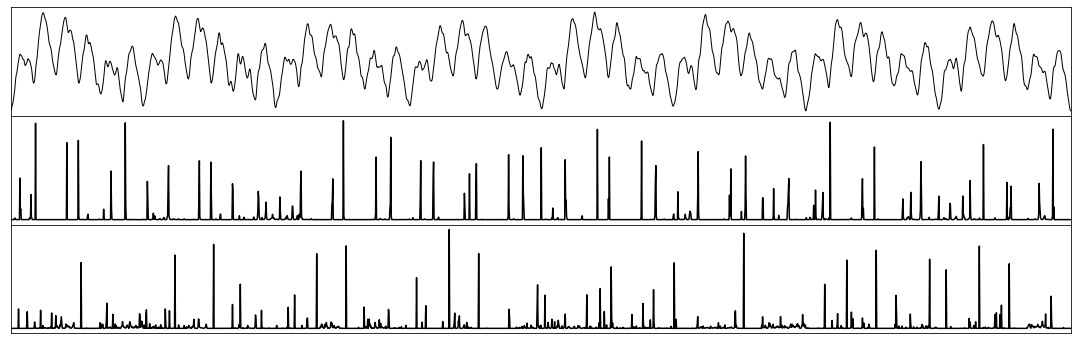

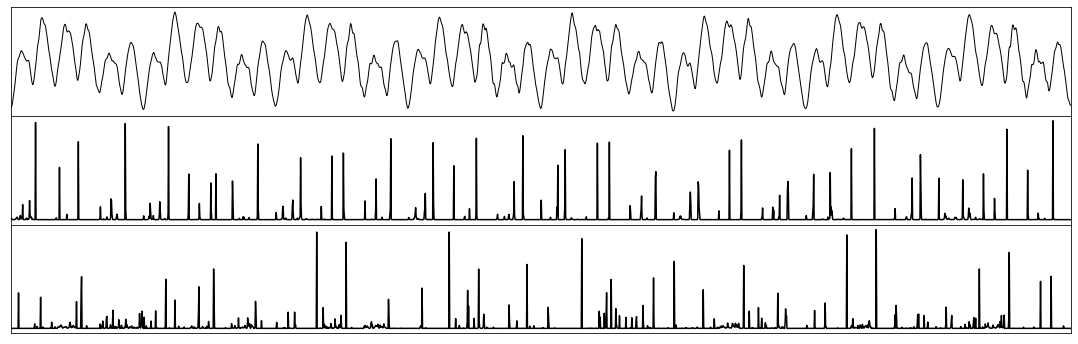

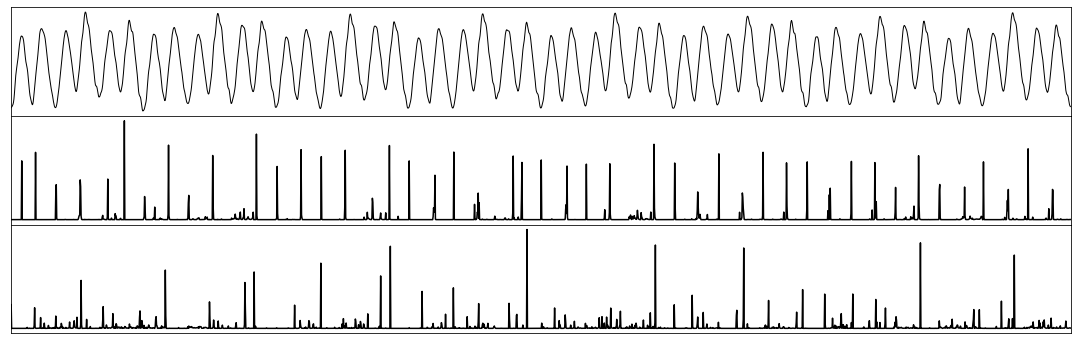

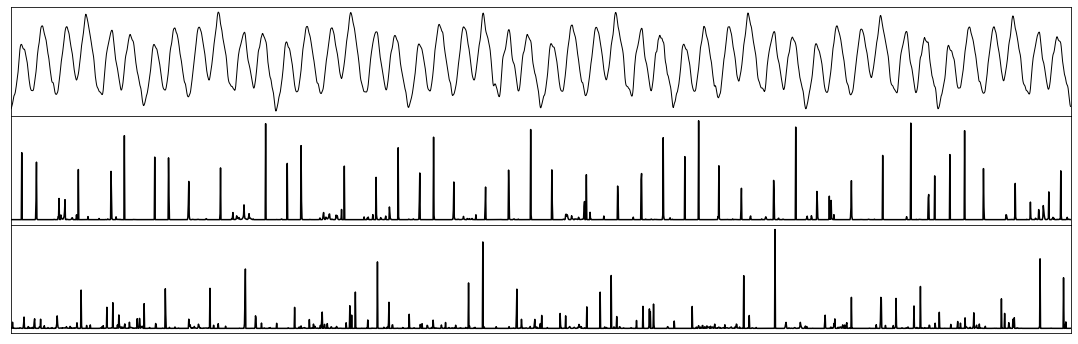

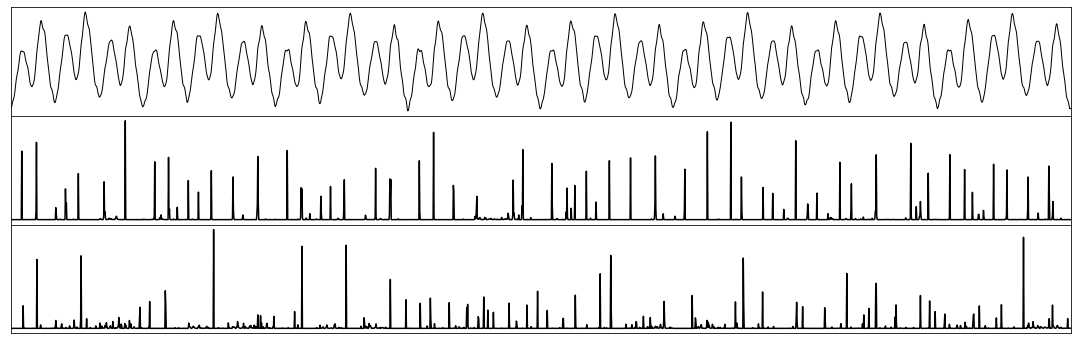

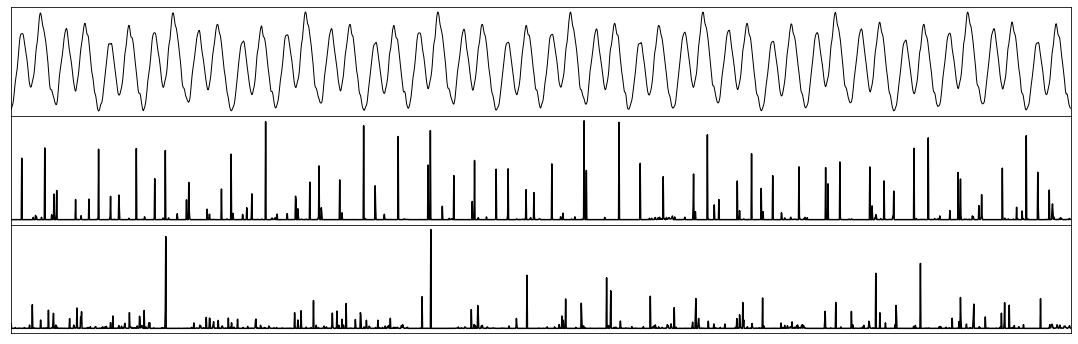

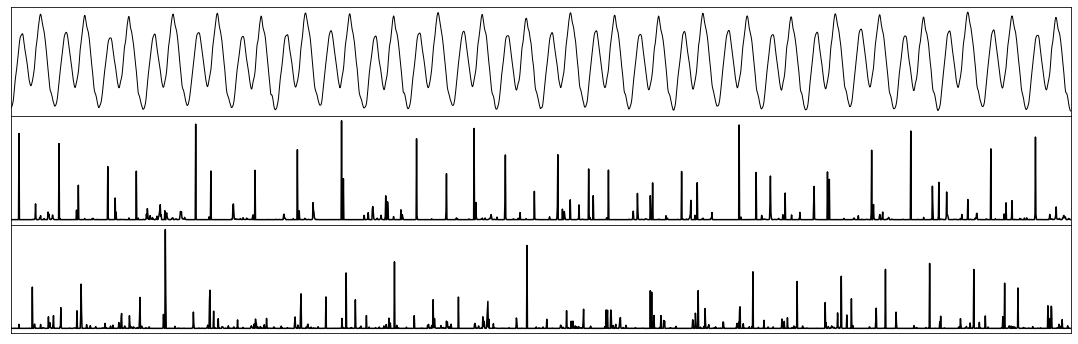

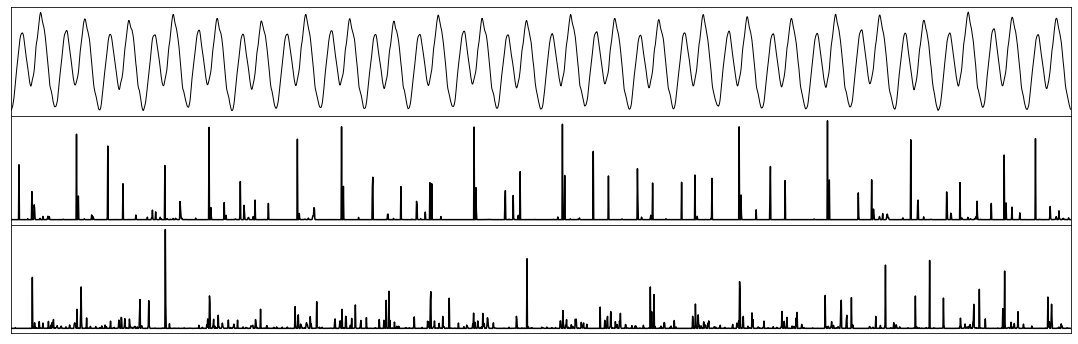

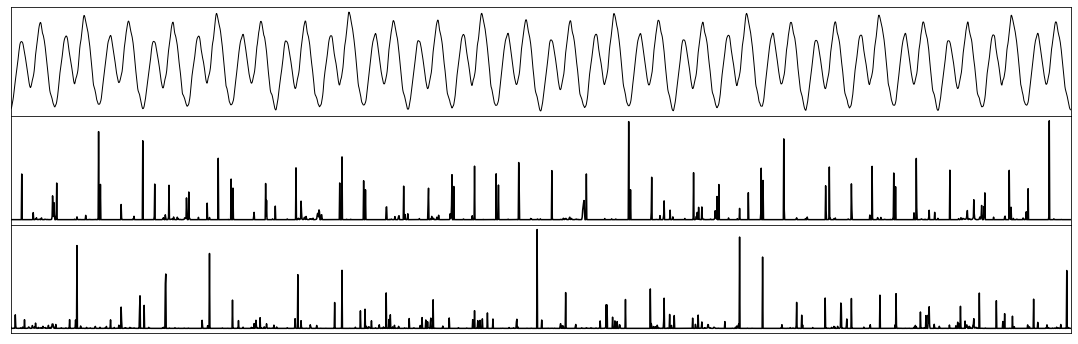

In [1]:
#注意力权重显示
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from matplotlib.patches import Rectangle


HIGHFREQ_INPUT_SIZE = [2304, 6]
LOWFREQ_INPUT_SIZE = [288, 7]
ATTENTION_RANGE = 48
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
sample_list = [150, 250, 350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250]

TESTDATA_1_LOADPATH = 'tool_wear_data_8/test_data1.npy' #验证集数据1读取路径

ATT_LOCAL_1_LOADPATH = 'attention_distribution_with_LSTM/attention_local.npy'#验证集注意力1读取路径
ATT_LOWHIGH_1_LOADPATH = 'attention_distribution_with_LSTM/attention_lowhigh.npy'
ATT_DETAIL_1_LOADPATH = 'attention_distribution_with_LSTM/attention_detail.npy'
ATT_LOCAL_2_LOADPATH = 'attention_distribution_without_LSTM/attention_local.npy'#验证集注意力2读取路径
ATT_LOWHIGH_2_LOADPATH = 'attention_distribution_without_LSTM/attention_lowhigh.npy'
ATT_DETAIL_2_LOADPATH = 'attention_distribution_without_LSTM/attention_detail.npy'

ATT_DIFF_SAVEPATH = 'attention_distribution_without_LSTM/attention_translation_differnece.png'
SIG_SAVEPATH = 'attention_distribution_without_LSTM/translated_signal.png'

for sample_index in sample_list:
    sample_index -= 5
    X_test = np.load(TESTDATA_1_LOADPATH)[sample_index, :, 0]

    att_local_1 = np.load(ATT_LOCAL_1_LOADPATH)[sample_index]
    att_lowhigh_1 = np.load(ATT_LOWHIGH_1_LOADPATH)[sample_index]
    att_detail_1 = np.load(ATT_DETAIL_1_LOADPATH)[sample_index]
    att_local_2 = np.load(ATT_LOCAL_2_LOADPATH)[sample_index]
    att_lowhigh_2 = np.load(ATT_LOWHIGH_2_LOADPATH)[sample_index]
    att_detail_2 = np.load(ATT_DETAIL_2_LOADPATH)[sample_index]

    fig_x = 19
    fig_y = 6
    plt.figure(figsize=(fig_x, fig_y))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplot(3, 1, 1)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, np.shape(X_test)[0])
    plt.plot(X_test, lw=1, color='black')
    plt.subplot(3, 1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, np.shape(att_detail_1)[0])
    plt.plot(att_detail_1, color='black')
    plt.subplot(3, 1, 3)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, np.shape(att_detail_2)[0])
    plt.plot(att_detail_2, color='black')

    plt.savefig(ATT_DIFF_SAVEPATH, dpi = 300, bbox_inches='tight')
    plt.show()

### 时域相似度比较

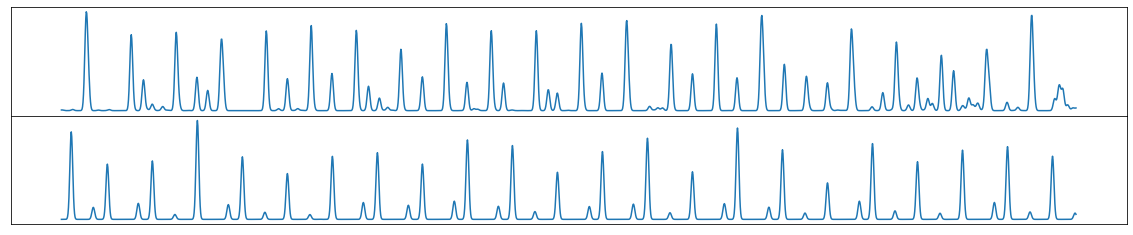

cosine_similarity 0.5497646579880082
shift_mean -6.382978723404255
shift_variance 73.86787702631932


In [3]:
#注意力权重显示
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from matplotlib.patches import Rectangle
from sklearn.metrics.pairwise import cosine_similarity

HIGHFREQ_INPUT_SIZE = [2304, 6]
LOWFREQ_INPUT_SIZE = [288, 7]
ATTENTION_RANGE = 48
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])

TESTDATA_1_LOADPATH = 'tool_wear_data_8/test_data1.npy' #验证集数据1读取路径
TESTDATA_2_LOADPATH = 'tool_wear_data_8/test_data2.npy' #验证集数据2读取路径

ATT_LOCAL_1_LOADPATH = 'attention_distribution_with_LSTM/attention_local.npy'#验证集注意力1读取路径
ATT_LOWHIGH_1_LOADPATH = 'attention_distribution_with_LSTM/attention_lowhigh.npy'
ATT_DETAIL_1_LOADPATH = 'attention_distribution_with_LSTM/attention_detail.npy'
ATT_LOCAL_2_LOADPATH = 'attention_distribution_without_LSTM/attention_local.npy'#验证集注意力1读取路径
ATT_LOWHIGH_2_LOADPATH = 'attention_distribution_without_LSTM/attention_lowhigh.npy'
ATT_DETAIL_2_LOADPATH = 'attention_distribution_without_LSTM/attention_detail.npy'

ATT_DIFF_SAVEPATH = 'attention_distribution_dataset9/attention_translation_differnece.png'
SIG_SAVEPATH = 'attention_distribution_dataset9/translated_signal.png'

acceptable_bias = 140

def gaussian_filtering(input_x, variation=3, filter_length=80):   #一维高斯滤波，输入方差、滤波器长度和输入
    filter_x = np.array(np.arange(-filter_length/2, filter_length/2))
    gauss_filter = np.exp(-pow(filter_x, 2)/(2*pow(variation, 2)))/(variation*np.sqrt(2*np.pi))
    gauss_filter = gauss_filter/np.sum(gauss_filter)
    filted_signal = np.convolve(input_x, gauss_filter, mode='same')
    return filted_signal

att_detail_1 = np.load(ATT_DETAIL_1_LOADPATH)
att_detail_3 = np.load(ATT_DETAIL_2_LOADPATH)

coco_matrix = np.zeros([int(np.shape(att_detail_1)[0]/30+1), acceptable_bias*2]) #Correlation coefficient， 一行一样本，一列一偏移
for i in range(0, np.shape(att_detail_1)[0], 30):
    for j in range(-acceptable_bias, acceptable_bias):
        if j > 0:
            att_sample_1 = gaussian_filtering(att_detail_1[i, j:])
            att_sample_3 = gaussian_filtering(att_detail_3[i, :-j])            
        elif j < 0:
            att_sample_1 = gaussian_filtering(att_detail_1[i, :j])
            att_sample_3 = gaussian_filtering(att_detail_3[i, -j:])
        else:
            att_sample_1 = gaussian_filtering(att_detail_1[i])
            att_sample_3 = gaussian_filtering(att_detail_3[i])
#         print('att_sample_1', np.shape(att_sample_1))
#         print('att_sample_3', np.shape(att_sample_3))
            
#         coco_matrix[int(i/20), j] = np.corrcoef(att_sample_1, att_sample_3)[0, 1]
        coco_matrix[int(i/30), j+acceptable_bias] = cosine_similarity([att_sample_1, att_sample_3])[0, 1]

#         print(coco_matrix[i, j])
        
fig_x = 20
fig_y = 4
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(2, 1, 1)
plt.xticks([])
plt.yticks([])
plt.plot(att_sample_1)
plt.subplot(2, 1, 2)
plt.xticks([])
plt.yticks([])
plt.plot(att_sample_3)
plt.show()

coco = np.max(coco_matrix, axis = 1)
loc = np.argmax(coco_matrix, axis = 1)
print('cosine_similarity', np.mean(coco))
print('shift_mean', np.mean(loc-acceptable_bias-1))
print('shift_variance', np.std(loc))

### 作图

(2304,)
(2304,)
(2304,)
0.48338539257381313


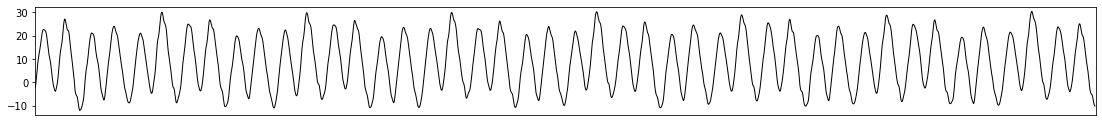

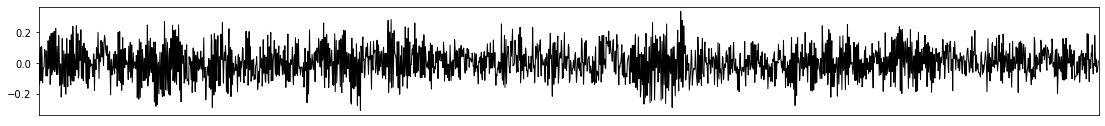

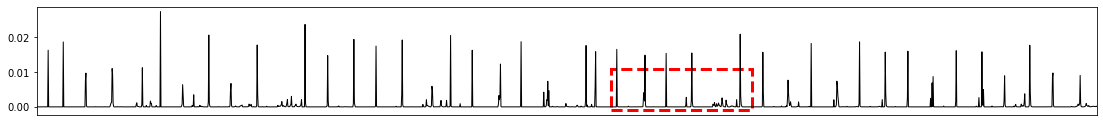

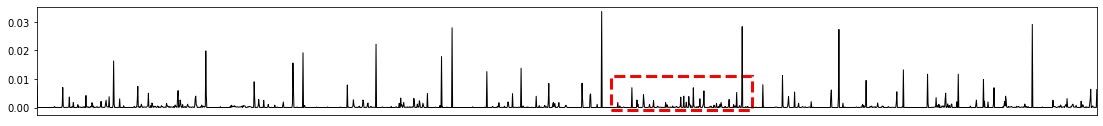

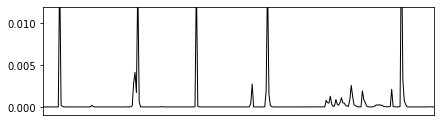

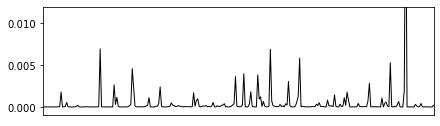

cosine_similarity 0.48338539257381313
shift_mean -2.0


In [52]:
#注意力权重显示
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from matplotlib.patches import Rectangle
from sklearn.metrics.pairwise import cosine_similarity



HIGHFREQ_INPUT_SIZE = [2304, 6]
LOWFREQ_INPUT_SIZE = [288, 7]
ATTENTION_RANGE = 48
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
sample_list = [645]
acceptable_bias = 200

TESTDATA_LOADPATH = 'tool_wear_data_8/test_data1.npy' #验证集数据1读取路径

ATT_LOCAL_1_LOADPATH = 'attention_distribution_with_LSTM/attention_local.npy'#验证集注意力1读取路径
ATT_LOWHIGH_1_LOADPATH = 'attention_distribution_with_LSTM/attention_lowhigh.npy'
ATT_DETAIL_1_LOADPATH = 'attention_distribution_with_LSTM/attention_detail.npy'
ATT_LOCAL_2_LOADPATH = 'attention_distribution_without_LSTM/attention_local.npy'#验证集注意力2读取路径
ATT_LOWHIGH_2_LOADPATH = 'attention_distribution_without_LSTM/attention_lowhigh.npy'
ATT_DETAIL_2_LOADPATH = 'attention_distribution_without_LSTM/attention_detail.npy'

ATT_DIFF1_SAVEPATH = 'attention_distribution_without_LSTM/attention_translation_differnece1.png'
ATT_DIFF2_SAVEPATH = 'attention_distribution_without_LSTM/attention_translation_differnece2.png'
ATT_DIFF3_SAVEPATH = 'attention_distribution_without_LSTM/attention_translation_differnece3.png'
ATT_DIFF4_SAVEPATH = 'attention_distribution_without_LSTM/attention_translation_differnece4.png'
SIG1_SAVEPATH = 'attention_distribution_without_LSTM/translated_signal1.png'
SIG2_SAVEPATH = 'attention_distribution_without_LSTM/translated_signal2.png'


def gaussian_filtering(input_x, variation=3, filter_length=80):   #一维高斯滤波，输入方差、滤波器长度和输入
    filter_x = np.array(np.arange(-filter_length/2, filter_length/2))
    gauss_filter = np.exp(-pow(filter_x, 2)/(2*pow(variation, 2)))/(variation*np.sqrt(2*np.pi))
    gauss_filter = gauss_filter/np.sum(gauss_filter)
#     plt.plot(gauss_filter)
#     plt.show()
    filted_signal = np.convolve(input_x, gauss_filter, mode='same')
    return filted_signal

for sample_index in sample_list:
    X_test_1 = np.load(TESTDATA_LOADPATH)[sample_index, :, 0]
    X_test_2 = np.load(TESTDATA_LOADPATH)[sample_index, :, 3]
    att_detail_1 = np.load(ATT_DETAIL_1_LOADPATH)[sample_index, :]
    att_detail_1 /= np.sum(att_detail_1)
    att_detail_2 = np.load(ATT_DETAIL_2_LOADPATH)[sample_index, :]
    att_detail_2 /= np.sum(att_detail_2)
    print(np.shape(X_test_1))
    print(np.shape(att_detail_1))
    print(np.shape(att_detail_2))
    
    coco_matrix = np.zeros(acceptable_bias*2) #Correlation coefficient， 一行一样本，一列一偏移
    for j in range(-acceptable_bias, acceptable_bias):
        if j > 0:
            att_sample_1 = gaussian_filtering(att_detail_1[j:])
            att_sample_2 = gaussian_filtering(att_detail_2[:-j])            
        elif j < 0:
            att_sample_1 = gaussian_filtering(att_detail_1[:j])
            att_sample_2 = gaussian_filtering(att_detail_2[-j:])
        else:
            att_sample_1 = gaussian_filtering(att_detail_1)
            att_sample_2 = gaussian_filtering(att_detail_2)
            
        coco_matrix[j+acceptable_bias] = cosine_similarity([att_sample_1, att_sample_2])[0, 1]
    loc = np.argmax(coco_matrix)
    coco = np.max(coco_matrix)
    print(coco)
    
fig_x = 19
fig_y = 2
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
plt.xticks([])
# plt.yticks([])
plt.xlim(0, np.shape(X_test_1[loc:])[0])
plt.plot(X_test_1[loc:], lw=1, color='black')
plt.savefig(SIG1_SAVEPATH, dpi = 400, bbox_inches='tight')
plt.show()

fig_x = 19
fig_y = 2
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
plt.xticks([])
# plt.yticks([])
plt.xlim(0, np.shape(X_test_2[loc:])[0])
plt.plot(X_test_2[loc:], lw=1, color='black')
plt.savefig(SIG2_SAVEPATH, dpi = 400, bbox_inches='tight')
plt.show()

x_start = 1140
x_length = 280
y_start = -0.001
y_length = 0.012

fig_x = 19
fig_y = 2
plt.figure(figsize=(fig_x, fig_y))
plt.xticks([])
# plt.yticks([])
plt.xlim(0, np.shape(att_detail_1)[0]-loc)
plt.gca().add_patch(Rectangle((x_start, y_start), x_length, y_length, fill=None, lw=3, ls='--', edgecolor="red"))
plt.plot(att_detail_1[-loc+acceptable_bias:], lw=1, color='black')
plt.savefig(ATT_DIFF1_SAVEPATH, dpi = 400, bbox_inches='tight')
plt.show()

fig_x = 19
fig_y = 2
plt.figure(figsize=(fig_x, fig_y))
plt.xticks([])
# plt.yticks([])
plt.xlim(0, np.shape(att_detail_1)[0]-loc)
plt.gca().add_patch(Rectangle((x_start, y_start), x_length, y_length, fill=None, lw=3, ls='--', edgecolor="red"))
plt.plot(att_detail_2[:loc-acceptable_bias], lw=1, color='black')
plt.savefig(ATT_DIFF2_SAVEPATH, dpi = 400, bbox_inches='tight')
plt.show()


#########注意力1的一部分########################
fig_x = 7
fig_y = 2
plt.figure(figsize=(fig_x, fig_y))
plt.xticks([])
# plt.yticks([])
plt.xlim(x_start, x_start+x_length)
plt.ylim(y_start, y_length)
plt.plot(att_detail_1[-loc+acceptable_bias:], lw=1, color='black')
plt.savefig(ATT_DIFF3_SAVEPATH, dpi = 400, bbox_inches='tight')
plt.show()

#########注意力2的一部分########################
fig_x = 7
fig_y = 2
plt.figure(figsize=(fig_x, fig_y))
plt.xticks([])
# plt.yticks([])
plt.xlim(x_start, x_start+x_length)
plt.ylim(y_start, y_length)
plt.plot(att_detail_2[-loc+acceptable_bias:], lw=1, color='black')
plt.savefig(ATT_DIFF4_SAVEPATH, dpi = 400, bbox_inches='tight')
plt.show()

coco = np.max(coco_matrix)
loc = np.argmax(coco_matrix)
print('cosine_similarity', np.mean(coco))
print('shift_mean', np.mean(loc-acceptable_bias-1))